# Improve Resolution with AutoEncoders

In [42]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from glob import glob

In [12]:
train_path='dataset/train'
val_path='dataset/val'

In [13]:
# Generating validation dataset
split=0.20

files=os.listdir(train_path)
count=0
for i in range(len(files)):
    if random.random()<split:
        file_path=os.path.join(train_path,files[i])
        new_path=os.path.join(val_path,files[i])
        os.rename(file_path,new_path)
        count+=1

In [20]:
train_images = glob(os.path.join(train_path,'*'))
val_images = glob(os.path.join(val_path,'*'))

Dims: (107, 79, 3)


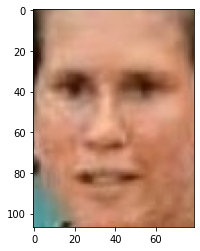

In [24]:
img_path=train_images[0]
img=cv2.imread(img_path)
print('Dims:', img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

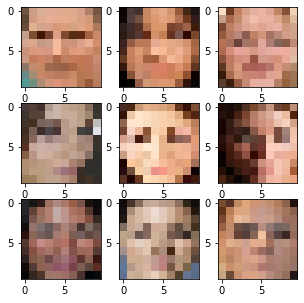

In [40]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img_path=train_images[-i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(10,10))
    plt.imshow(img)


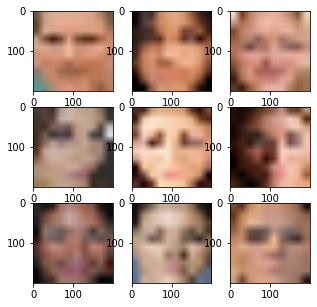

In [41]:
# Upsampling the images - using CV2

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img_path=train_images[-i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(10,10))
    img=cv2.resize(img,(200,200))
    plt.imshow(img)


# 
Reading the image from the dataset
squeezing the size to 10px - lets suppose we degrade the quality of image
then using cv2 we are trying to recover that with 200x200 image size

also comparing with the decoder doing the same operation on the image
trained on - 10x10 image and the output is the real image 

I want to see how close the neural net can go in completing the image from the latent space
this code can be used in the case where the image is squeezed due to bad image quality or other issues but we are resizing it - without using interpolation or other process.

Expectation - the image from the decoder should be more life like and real 
as compared to the cv2 form

In [60]:
# This class is a basic data loader - that is used to prepare and create
# the test train dataset - that is then fed into the network

class DataLoader:
    def __init__(self, data_dir, downsample_shape=(10,10),target_shape=(200,200)):
        self.files = self.load_files(data_dir)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.downsample_shape = downsample_shape
        self.target_shape = target_shape
    
    @staticmethod
    def load_files(root_dir):
        if not root_dir.endswith('*'):
            root_dir = os.path.join(root_dir, '*')
        return tf.data.Dataset.list_files(root_dir, shuffle=True)
    
    def process_image(self, image_path):
        img=tf.io.read_file(image_path)
        img=tf.io.decode_jpeg(img)
        
        # the input image is just 10x10 image nothing else
        input_image = tf.image.resize(img, self.downsample_shape)/255.
        
        # we dont want them to have same shape - it will learn the
        # resizing operation, interpolation or identity from the current image
        # input_image = tf.image.resize(img, self.target_shape)/255.
        
        # to make all the images squared - easy for neural net
        target_image = tf.image.resize(img, self.target_shape)/255.
        
        return input_image, target_image
    
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.process_image)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset


In [67]:
test_dataset = DataLoader(train_path)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))

print('\n\n\n',' # '*10)
print(f'Input Shape: {inputs.shape}, Target Shape: {targets.shape}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'





  #  #  #  #  #  #  #  #  #  # 
Input Shape: (10, 10, 10, 3), Target Shape: (10, 200, 200, 3)


In [64]:
# Can also be set using the AUTOGRAPH_VERBOSITY environment variable
tf.autograph.set_verbosity(0)

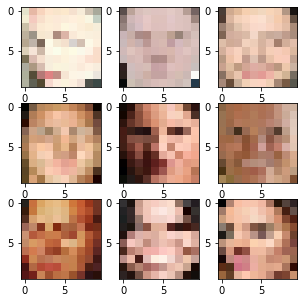

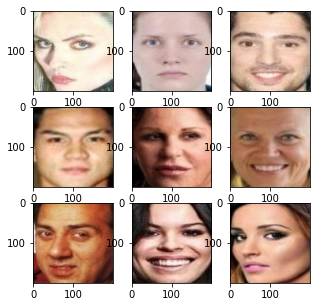

In [69]:
# Data Loader Testing 

# Inputs
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img=inputs[i]
    plt.imshow(img)

# Targets
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img=targets[i]
    plt.imshow(img)

## Model Structure and Training

In [72]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, Add


In [ ]:
# callbacks

early_stop_cb = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=4,
                verbose=1,
                mode='auto',
                baseline=None,
                restore_best_weights=True)

model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
                'resize_weights.h5',
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                mode='auto',
                save_freq='epoch')

reduce_lr_cb=tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=4,
                verbose=1,
                mode='auto',
                min_delta=0.0001,
                cooldown=0,
                min_lr=10e-8)

# Model Structure

